In [1]:
# Cell 1: Enhanced Imports and Setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download required NLTK data
for package in ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger']:
    nltk.download(package)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Dataset Statistics:
Total samples: 328

Label distribution:
label
DISTRIBUTORS             0.103659
EMI                      0.076220
MATTRESS_COST            0.067073
PRODUCT_VARIANTS         0.064024
LEAD_GEN                 0.064024
ORDER_STATUS             0.064024
WHAT_SIZE_TO_ORDER       0.060976
100_NIGHT_TRIAL_OFFER    0.054878
ORTHO_FEATURES           0.051829
RETURN_EXCHANGE          0.042683
COD                      0.036585
COMPARISON               0.033537
ERGO_FEATURES            0.033537
DELAY_IN_DELIVERY        0.033537
ABOUT_SOF_MATTRESS       0.033537
WARRANTY                 0.030488
CHECK_PINCODE            0.030488
PILLOWS                  0.030488
CANCEL_ORDER             0.030488
OFFERS                   0.030488
SIZE_CUSTOMIZATION       0.027439
Name: proportion, dtype: float64


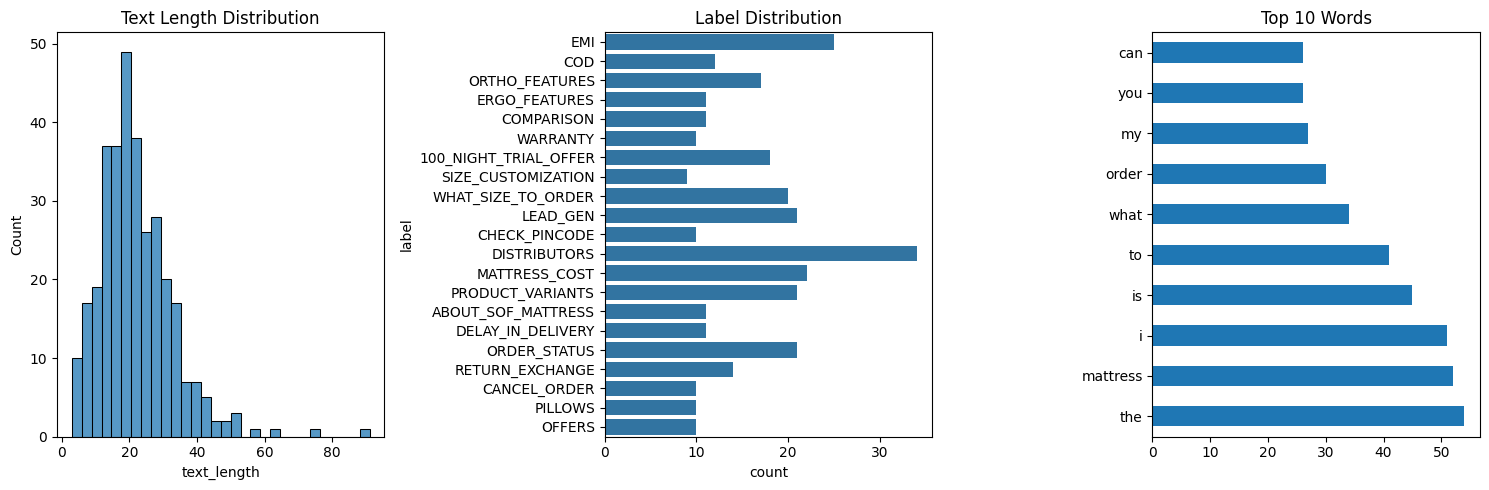

In [3]:
# Cell 2: Advanced Data Loading and Analysis
def load_and_analyze_data(file_path):
    # Load data
    data = pd.read_csv(file_path)

    # Basic statistics
    print("Dataset Statistics:")
    print(f"Total samples: {len(data)}")
    print("\nLabel distribution:")
    print(data['label'].value_counts(normalize=True))

    # Text length analysis
    data['text_length'] = data['sentence'].str.len()

    plt.figure(figsize=(15, 5))

    # Plot text length distribution
    plt.subplot(1, 3, 1)
    sns.histplot(data=data, x='text_length', bins=30)
    plt.title('Text Length Distribution')

    # Plot label distribution
    plt.subplot(1, 3, 2)
    sns.countplot(data=data, y='label')
    plt.title('Label Distribution')

    # Word frequency analysis
    all_words = ' '.join(data['sentence']).lower().split()
    word_freq = Counter(all_words)

    # Plot top words
    plt.subplot(1, 3, 3)
    pd.Series(dict(word_freq.most_common(10))).plot(kind='barh')
    plt.title('Top 10 Words')

    plt.tight_layout()
    plt.show()

    return data

# Load and analyze data
data = load_and_analyze_data('/content/sofmattress_train.csv')


In [5]:
# Cell 3: Advanced Text Preprocessing
import nltk
nltk.download('punkt_tab')
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english')) - {'no', 'not', 'zero', 'percent'}

    def clean_text(self, text):
        # Convert to lowercase
        text = str(text).lower()

        # Remove special characters but keep important symbols
        text = re.sub(r'[^a-zA-Z0-9%\s]', '', text)

        # Tokenization
        tokens = word_tokenize(text)

        # Lemmatization with POS tagging
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Remove stopwords
        tokens = [token for token in tokens if token not in self.stop_words]

        # Generate n-grams (bigrams)
        bigrams = [' '.join(bg) for bg in ngrams(tokens, 2)]

        # Combine unigrams and bigrams
        final_tokens = tokens + bigrams

        return ' '.join(final_tokens)

    def extract_features(self, text):
        # Additional feature extraction
        features = {
            'text_length': len(text),
            'word_count': len(text.split()),
            'has_number': int(bool(re.search(r'\d', text))),
            'has_percent': int('%' in text),
            'has_emi': int('emi' in text.lower())
        }
        return features

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing
data['cleaned_text'] = data['sentence'].apply(preprocessor.clean_text)
feature_data = pd.DataFrame([preprocessor.extract_features(text) for text in data['sentence']])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
# Cell 4: Advanced Feature Engineering
# BERT Feature Extraction
def get_bert_features(texts, max_length=128):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')

    features = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', max_length=max_length,
                             truncation=True, padding='max_length')
            outputs = model(**inputs)
            # Use [CLS] token embeddings
            features.append(outputs.last_hidden_state[:, 0, :].numpy())

    return np.vstack(features)

# TF-IDF Features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(data['cleaned_text'])

# Combine all features
X_bert = get_bert_features(data['sentence'])
X_additional = feature_data.values
X_combined = np.hstack([X_tfidf.toarray(), X_bert, X_additional])

# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
# Cell 5: Advanced Model Architecture
def create_deep_learning_model(input_shape, num_classes):
    # Input layers
    text_input = tf.keras.Input(shape=(input_shape,))

    # Dense layers with residual connections
    x = tf.keras.layers.Dense(256, activation='relu')(text_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Residual block 1
    residual = x
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Add()([x, residual])

    # Residual block 2
    residual = x  # Assign residual before changing x's shape
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Apply a Dense layer to residual to match the shape of x
    residual = tf.keras.layers.Dense(128, activation='relu')(residual)
    x = tf.keras.layers.Add()([x, residual])

    # Output layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=text_input, outputs=output)
    return model

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 849ms/step - accuracy: 0.0677 - loss: 4.8717 - val_accuracy: 0.0189 - val_loss: 3.4150 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2699 - loss: 2.9368 - val_accuracy: 0.0189 - val_loss: 3.3846 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2579 - loss: 2.3855 - val_accuracy: 0.0377 - val_loss: 3.2861 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4689 - loss: 2.0271 - val_accuracy: 0.0189 - val_loss: 3.3121 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5456 - loss: 1.5460 - val_accuracy: 0.0189 - val_loss: 3.2739 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6296 - loss: 1.2016 - val_accuracy: 0.0943 - val_loss: 3.0595 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6907 - loss: 1.0952 - val_accuracy: 0.150

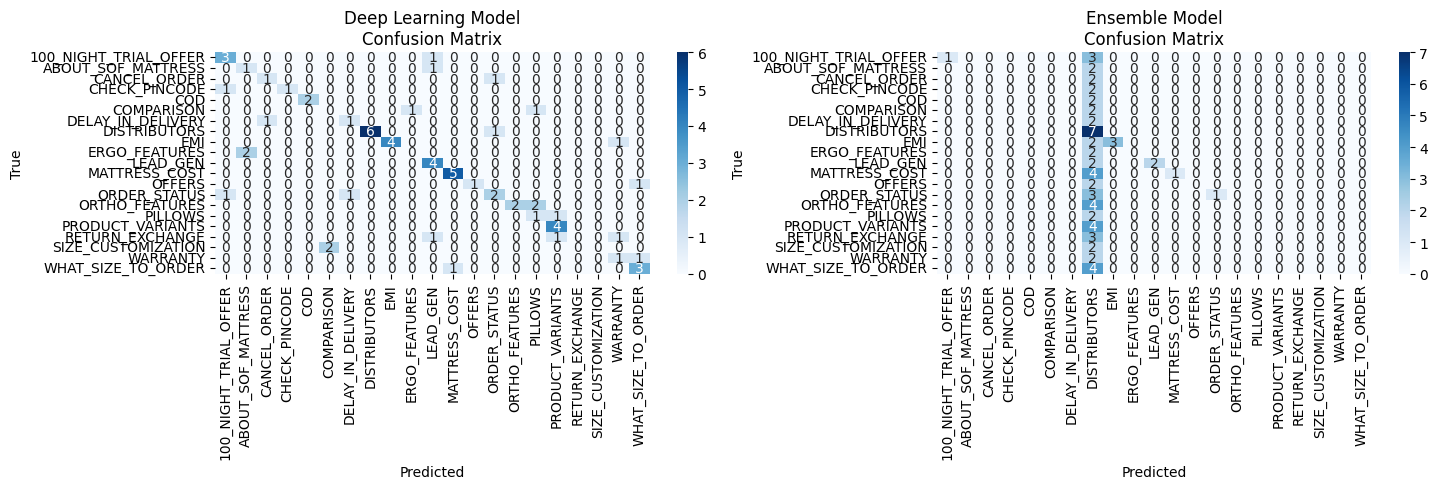

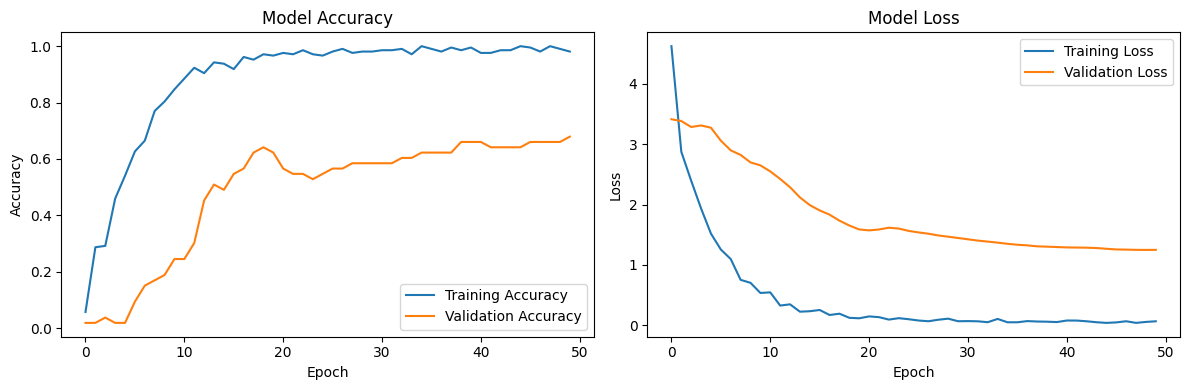

In [12]:
# Cell 6: Model Training and Evaluation (Fixed)
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Create and train models
# 1. Deep Learning Model
dl_model = create_deep_learning_model(X_train.shape[1], len(label_encoder.classes_))
dl_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Train deep learning model
history = dl_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# 2. Ensemble of Traditional Models
# Create pipelines for each model to handle preprocessing
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', CalibratedClassifierCV(LinearSVC(random_state=42)))
])

rf_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])

nb_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('nb', MultinomialNB())
])

# Create ensemble with pipelines
ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_pipeline),
        ('rf', rf_pipeline),
        ('nb', nb_pipeline)
    ],
    voting='soft'
)

# Fit the ensemble
ensemble.fit(X_train, y_train)

# Evaluate models
print("Evaluating models...")

# Deep Learning evaluation
dl_pred = dl_model.predict(X_test)
dl_pred_classes = np.argmax(dl_pred, axis=1)
print("\nDeep Learning Model Performance:")
print(classification_report(y_test, dl_pred_classes,
                          target_names=label_encoder.classes_))

# Ensemble evaluation
ensemble_pred = ensemble.predict(X_test)
print("\nEnsemble Model Performance:")
print(classification_report(y_test, ensemble_pred,
                          target_names=label_encoder.classes_))

# Plot confusion matrices
plt.figure(figsize=(15, 5))

# Deep Learning confusion matrix
plt.subplot(1, 2, 1)
cm_dl = confusion_matrix(y_test, dl_pred_classes)
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Deep Learning Model\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Ensemble confusion matrix
plt.subplot(1, 2, 2)
cm_ensemble = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Ensemble Model\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Plot training history for deep learning model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


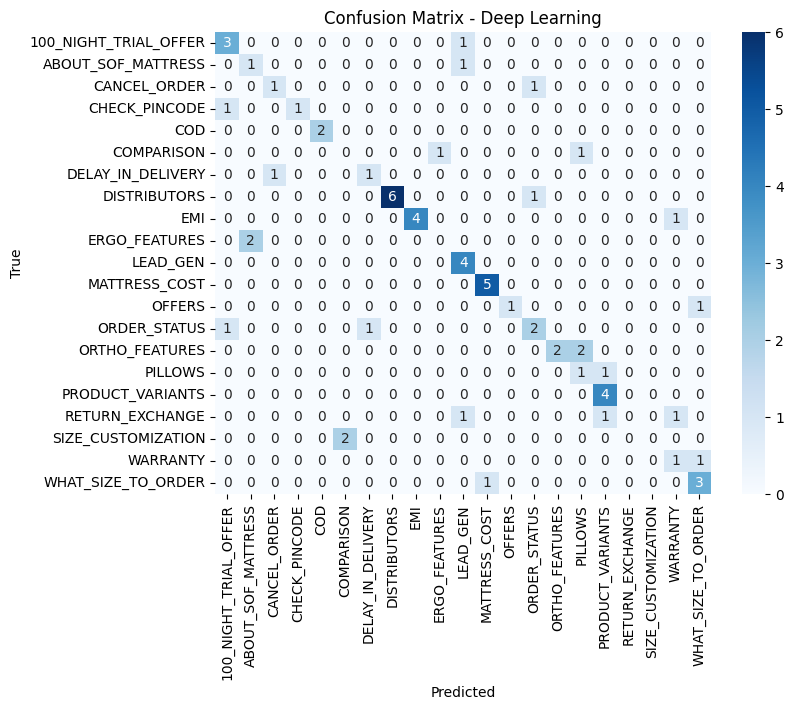

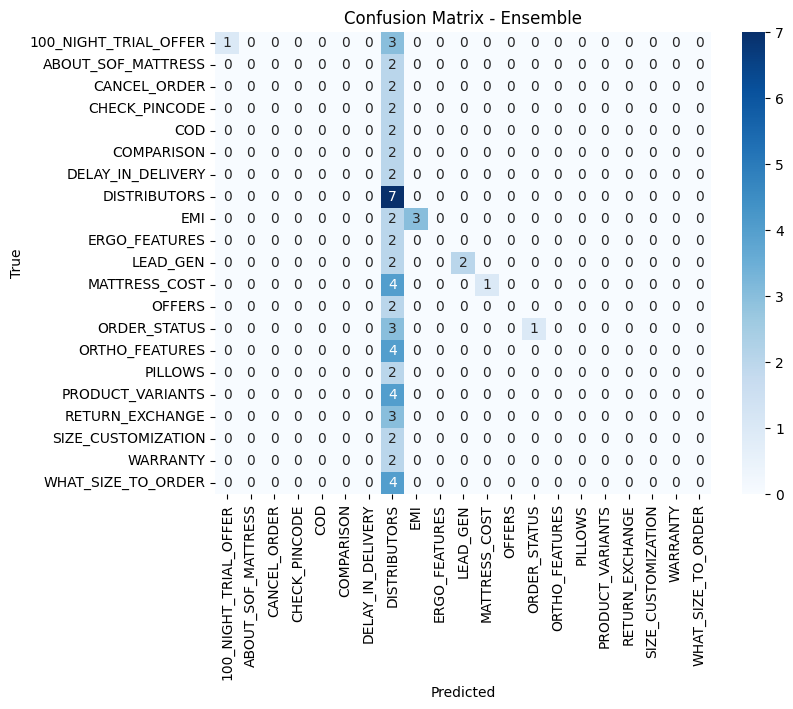

In [13]:
# Cell 7: Advanced Evaluation and Analysis
def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        if isinstance(model, tf.keras.Model):
            y_pred = model.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)
        else:
            y_pred = model.predict(X_test)

        # Calculate metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'report': classification_report(y_test, y_pred,
                                         target_names=label_encoder.classes_,
                                         output_dict=True)
        }

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return results

# Evaluate all models
models = {
    'Deep Learning': dl_model,
    'Ensemble': ensemble
}

evaluation_results = evaluate_models(models, X_test, y_test)


In [32]:
# Cell 8: Advanced Prediction System
class IntentDetectionSystem:
    def __init__(self, models, preprocessor, label_encoder, tfidf):
        self.models = models
        self.preprocessor = preprocessor
        self.label_encoder = label_encoder
        self.tfidf = tfidf

    def predict(self, text, threshold=0.5):
        # Preprocess text
        cleaned_text = self.preprocessor.clean_text(text)
        features = self.preprocessor.extract_features(text)

        # Generate features
        tfidf_features = self.tfidf.transform([cleaned_text]).toarray()
        bert_features = get_bert_features([text])
        additional_features = np.array([list(features.values())])

        # Combine features
        X = np.hstack([tfidf_features, bert_features, additional_features])

        # Get predictions from all models
        predictions = {}
        confidences = {}

        for name, model in self.models.items():
            if isinstance(model, tf.keras.Model):
                pred_probs = model.predict(X)[0]
                pred_class = np.argmax(pred_probs)
                confidence = pred_probs[pred_class]
            else:
                pred_probs = model.predict_proba(X)[0]
                pred_class = np.argmax(pred_probs)
                confidence = pred_probs[pred_class]

            pred_label = self.label_encoder.inverse_transform([pred_class])[0]
            predictions[name] = pred_label
            confidences[name] = confidence

        # Ensemble decision
        final_prediction = max(predictions.items(),
                             key=lambda x: confidences[x[0]])[1]

        return {
            'prediction': final_prediction,
            'model_predictions': predictions,
            'confidences': confidences,
            'features': features
        }

# Initialize the system
intent_system = IntentDetectionSystem(models, preprocessor, label_encoder, tfidf)

# Test the system
test_texts = [
    "You guys provide EMI option?",
    "Do you offer COD to my pincode?",
    "I am cervical and Lombard section problem",
    "Difference between the products",
    "Tell me about the product warranty",
    "Need 100 days trial",
    "Customisation is possible?",
    "Want to know the custom size chart",
    "Get In Touch",
    "Do you deliver to",
    "Is there any offline stores ",
    "How Much Cost",
    "Type of foam used"
    "Tell me about SOF mattresses",
    "Where is my product",
    "Process of cancelling order",
    "Need pair of Pillows",
    "What are the available offers"
]

print("\nTest predictions:")
for text in test_texts:
    result = intent_system.predict(text)
    print(f"\nText: {text}")
    print("Final Prediction:", result['prediction'])
    print("Model Predictions:", result['model_predictions'])
    print("Confidences:", {k: f"{v:.3f}" for k, v in result['confidences'].items()})


Test predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Text: You guys provide EMI option?
Final Prediction: EMI
Model Predictions: {'Deep Learning': 'EMI', 'Ensemble': 'EMI'}
Confidences: {'Deep Learning': '0.996', 'Ensemble': '0.764'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Text: Do you offer COD to my pincode?
Final Prediction: COD
Model Predictions: {'Deep Learning': '100_NIGHT_TRIAL_OFFER', 'Ensemble': 'COD'}
Confidences: {'Deep Learning': '0.336', 'Ensemble': '0.414'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Text: I am cervical and Lombard section problem
Final Prediction: ORTHO_FEATURES
Model Predictions: {'Deep Learning': 'ORTHO_FEATURES', 'Ensemble': 'ORTHO_FEATURES'}
Confidences: {'Deep Learning': '0.885', 'Ensemble': '0.581'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Text: Difference between the products
Final Prediction: COMPARISON
Model Predictions: {'Deep Learning': 'COMPARISON', 'Ensemble': 'COMPARISON'}
Confidences: {'Deep Learning': '0.999', 'Ensemble': '0.374'}
1/1 ━━━━━━

In [33]:
def analyze_errors(model, X_test, y_test, label_encoder):
    if isinstance(model, tf.keras.Model):
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = model.predict(X_test)

    errors = []
    for i, (true, pred) in enumerate(zip(y_test, y_pred)):
        if true != pred:
            errors.append({
                'true_label': label_encoder.inverse_transform([true])[0],
                'predicted_label': label_encoder.inverse_transform([pred])[0],
                'index': i
            })

    return pd.DataFrame(errors)


In [34]:
import joblib

# Save the ensemble model, TF-IDF vectorizer, label encoder, and preprocessor using joblib
joblib.dump(ensemble, 'ensemble_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(preprocessor, 'text_preprocessor.pkl')

# Save the deep learning model using Keras' built-in save method (H5 format)
dl_model.save('deep_learning_model.h5')

print("All models and artifacts have been saved successfully!")


All models and artifacts have been saved successfully!


In [35]:
# Zip the files into a single archive
!zip models.zip ensemble_model.pkl tfidf_vectorizer.pkl label_encoder.pkl text_preprocessor.pkl deep_learning_model.h5

# Download the zip file
from google.colab import files
files.download("models.zip")


  adding: ensemble_model.pkl (deflated 80%)
  adding: tfidf_vectorizer.pkl (deflated 78%)
  adding: label_encoder.pkl (deflated 29%)
  adding: text_preprocessor.pkl (deflated 48%)
  adding: deep_learning_model.h5 (deflated 23%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>